In [23]:
# !pip install lxml matplotlib

In [2]:
import xml.etree.ElementTree as ET
import albumentations as A
import os, shutil, re, json
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
DATA_PATH = os.path.abspath(os.path.join("../../..", "Seafile", "Detecting-Objects", "DataCollection"))
IMAGE_PATH = os.path.join(DATA_PATH, "images")
LABEL_PATH = os.path.join(DATA_PATH, "labels")

TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
VAL_PATH = os.path.join(DATA_PATH, 'val')

TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.1
VAL_SPLIT = 0.1

In [26]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = [int(coord) for coord in bbox]
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, class_names):
    img = image.copy()
    for bbox, class_name in zip(bboxes, class_names):
        img = visualize_bbox(img, bbox, class_name)
    plt.imshow(img)
    plt.show()

## Convert single label

In [22]:
file_name = "5787e682-708a-11ed-b2e3-1b1b14efb1a9"
OBJECT_CLASS = "cup"

In [14]:
def get_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()

    label = root.find('object').find('name').text
    width = int(root.find('size')[0].text)
    height = int(root.find('size')[1].text)    

    xmin = int(root.find('object').find('bndbox').find('xmin').text)
    ymin = int(root.find('object').find('bndbox').find('ymin').text)
    xmax = int(root.find('object').find('bndbox').find('xmax').text)
    ymax = int(root.find('object').find('bndbox').find('ymax').text)
    
    coords = [xmin, ymin, xmax, ymax]
    
    return coords, label, width, height
    
#get_annotation(f"{os.path.join(LABEL_PATH, OBJECT_CLASS, file_name)}.xml")

## Create augmentor

In [29]:
WIDTH, HEIGHT = 640, 640

# create resize transform pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.25),
    A.RandomBrightnessContrast(p=0.2),
    A.LongestMaxSize(max_size=WIDTH, interpolation=1),
    A.PadIfNeeded(min_height=WIDTH, min_width=WIDTH, border_mode=0, value=(0,0,0))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Resize and transform image (i.e. rotate, brightness)
def resize_transform_image(img_arr, bboxes, class_labels):
    orig_img = img_arr.copy()
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param class_labels: list of labels for the bboxes
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """

    return transform(image=orig_img, bboxes=bboxes, class_labels=class_labels)


resize_transform = A.Compose([
     A.LongestMaxSize(max_size=WIDTH, interpolation=1),
    A.PadIfNeeded(min_height=WIDTH, min_width=WIDTH, border_mode=0, value=(0,0,0))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Resize image without additional transformations
def resize_image(img_arr, bboxes, class_labels):
    orig_img = img_arr.copy()
    return resize_transform(image=orig_img, bboxes=bboxes, class_labels=class_labels)

In [11]:
def augment_image(resize_fun, new_image_name, image, coords, label, width, height):
    # Augment raw image
    transformed = resize_fun(train_img, [coords], [label])

    # Save augmented image
    cv2.imwrite(os.path.join(path, 'aug', f"{new_image_name}.jpg"), cv2.cvtColor(transformed['image'], cv2.COLOR_BGR2RGB))

    # Save augmented label
    annotation = {}
    annotation['bboxes'] = transformed['bboxes'][0]
    annotation['class'] = transformed['class_labels'][0]
    annotation['width'] = width
    annotation['height'] = height

    with open(os.path.join(path, 'aug', f"{new_image_name}.json"), 'w') as f:
        json.dump(annotation, f)

### Test augmentation on single image

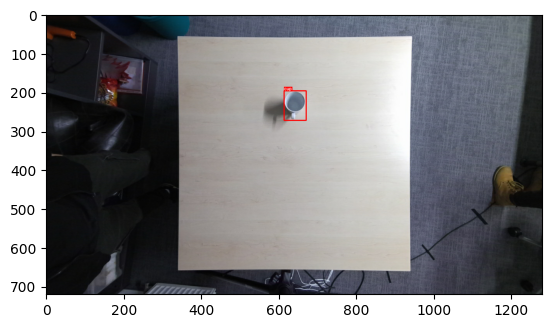

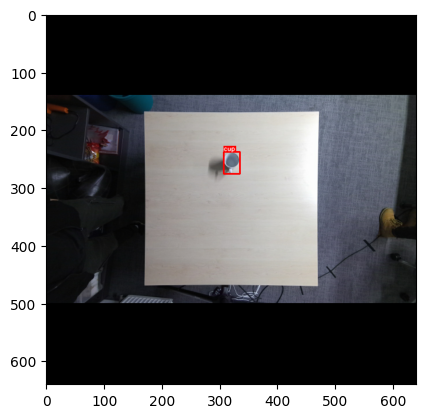

In [30]:
coords, label, width, height = get_annotation(f"{os.path.join(LABEL_PATH, OBJECT_CLASS, file_name)}.xml")
image = cv2.imread(os.path.join(IMAGE_PATH, OBJECT_CLASS, 'rgb', f'{file_name}.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Visualize raw image
visualize(image, [coords], [label])

# Visualize augmented image
transformed = resize_image(image, [coords], [label])
visualize(transformed['image'], transformed['bboxes'], transformed['class_labels'])

### Partition data into train, test, val set

In [10]:
from sklearn.model_selection import train_test_split

# Create train, test, val partition from our 3 classes (rock, paper, scissors)
def create_partition(image_path):
    for folder in os.listdir(image_path):
        if folder.startswith('.'):
            continue
        
        # Read images and labels from directory
        images = [image for image in os.listdir(os.path.join(IMAGE_PATH, folder, 'rgb')) if not image.startswith('.')]
        labels = [label for label in os.listdir(os.path.join(LABEL_PATH, folder)) if not label.startswith('.')]
        
        # Split into train test validation set. From: https://datascience.stackexchange.com/a/53161
        X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=1 - TRAIN_SPLIT, random_state=1337)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=TEST_SPLIT / (TEST_SPLIT + VAL_SPLIT), random_state=1337)        
        
        # Create folder 
        for folder_path in [TRAIN_PATH, TEST_PATH, VAL_PATH]:            
            if not os.path.exists(folder_path):
                os.mkdir(folder_path)
        
        # Copy files and labels to train, test, val folders
        for file_name in X_train:
            shutil.copy(os.path.join(IMAGE_PATH, folder, 'rgb', file_name), TRAIN_PATH)
            shutil.copy(os.path.join(LABEL_PATH, folder, f"{file_name.split('.')[0]}.xml"), TRAIN_PATH)
            
        for file_name in X_test:
            shutil.copy(os.path.join(IMAGE_PATH, folder, 'rgb', file_name), TEST_PATH)
            shutil.copy(os.path.join(LABEL_PATH, folder, f"{file_name.split('.')[0]}.xml"), TEST_PATH)
            
        for file_name in X_val:
            shutil.copy(os.path.join(IMAGE_PATH, folder, 'rgb', file_name), VAL_PATH)
            shutil.copy(os.path.join(LABEL_PATH, folder, f"{file_name.split('.')[0]}.xml"), VAL_PATH)
            
create_partition(IMAGE_PATH)

### Augment both images and labels
Apply resizing and transformations to TRAIN set while only resizing images in TEST and VALIDATION sets 

In [31]:
for path in [TRAIN_PATH, TEST_PATH, VAL_PATH]:
    train_images = [file for file in os.listdir(path) if re.match(r'.*\.(jpg|jpeg|png)', file)]
    
    aug_path = os.path.join(path, 'aug')
    if not os.path.exists(aug_path):
        os.mkdir(aug_path)

    for train_image_name in train_images:
        new_image_name = train_image_name.split(".")[0]

        # Read image data
        train_img = cv2.imread(os.path.join(path, train_image_name))
        train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

        # Read annotation
        coords, label, w, h  = get_annotation(os.path.join(path, f"{new_image_name}.xml"))
        
        if path != TRAIN_PATH:
            augment_image(resize_image, new_image_name, train_img, coords, label, w, h)
        else:
            for x in range(1, 20):
                augment_image(resize_transform_image, f"{new_image_name}_{x}", train_img, coords, label, w, h)